## Импорт бибиотек

In [1]:
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


import torch

2024-03-19 14:23:26.772562: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 14:23:26.772905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 14:23:26.869776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 14:23:27.090876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 14:23:28.908256: W tensorflow/compiler/tf2

In [2]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
import pandas as pd

In [4]:
## Загрузка датасета

In [5]:
df = pd.read_csv('../dataset/imdb_data.csv', encoding='utf8')

In [6]:
df=df[:14000]

In [7]:
df["sentiment"] = np.where(df["sentiment"] == "positive", 1, 0)

In [8]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
13995,"Bad acting, bad lighting, bad plot!! This had ...",0
13996,Strange but acceptable mob comedy that has an ...,1
13997,"I saw this movie a few years ago, and man I ne...",0
13998,I was interested in the title and description ...,0


In [9]:
pos_df=df[df['sentiment'] == 1]
neg_df=df[df['sentiment'] == 0]
pos_df.reset_index()
neg_df.reset_index()

,index,review,sentiment
0,3,Basically there's a family where a little boy ...,0
1,7,"This show was an amazing, fresh & innovative i...",0
2,8,Encouraged by the positive comments about this...,0
3,10,Phil the Alien is one of those quirky films wh...,0
4,11,I saw this movie when I was about 12 when it c...,0
...,...,...,...
7070,13994,You know that feeling of hilarity you get when...,0
7071,13995,"Bad acting, bad lighting, bad plot!! This had ...",0
7072,13997,"I saw this movie a few years ago, and man I ne...",0
7073,13998,I was interested in the title and description ...,0


In [10]:
pos_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6925 entries, 0 to 13996
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     6925 non-null   object
 1   sentiment  6925 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 162.3+ KB


In [11]:
neg_df.sample(5)

,review,sentiment
9674,"What's wrong with this film? Many, many things...",0
3277,I have to admit I was deceived by the title an...,0
12106,"You'll notice that the chemist, who appears in...",0
12040,"In the U.S., very few films have been made abo...",0
4892,From the start this film drags and drags. Clum...,0


In [12]:
sentences = np.concatenate([pos_df['review'], neg_df['review']])

sentences = ["[CLS] " + sentence[:256] + " [SEP]"  if len(sentence) > 256 else ("[CLS] " + sentence + " [SEP]" ) for sentence in sentences]
labels = [[1] for _ in range(pos_df.shape[0])] + [[0] for _ in range(neg_df.shape[0])]

In [13]:
len(sentences)

14000

In [14]:
assert len(sentences) == len(labels) == pos_df.shape[0] + neg_df.shape[0]

In [15]:
print(sentences[1])

[CLS] A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Mich [SEP]


In [16]:
max(sentences)

'[CLS] {rant start} I didn\'t want to believe them at first, but I guess this is what people are talking about when they say South Korean cinema has peaked and may even be going downhill. After the surprisingly fun and moving monster movie "Gwoemul" (aka "The Host [SEP]'

## Разбиение на тестовую и обучающую выборку

In [17]:
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import numpy as np

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [18]:
print(len(train_gt), len(test_gt))

9800 4200


In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True,model_max_length=256)
tokenized_texts = []

In [20]:
# 45 секунд
def process(distances, start, end):
    try:
        for s in distances[start:end]:
            tokenized_texts.append(tokenizer.encode(s))
            #count = np.sum(s > 0.81)
            #top_keyphrases.append(count)
    except Exception as e:
        print(f'Error: {e}')

def split_processing(distances, num_splits=64):
    split_size = len(distances) // num_splits
    with ThreadPoolExecutor(max_workers=num_splits) as executor:
        futures = []
        for i in range(num_splits):
            start = i * split_size
            end = None if i + 1 == num_splits else (i + 1) * split_size
            futures.append(
                executor.submit(process, distances, start, end)
            )

        # wait for all futures to finish
        for future in futures:
            future.result()
# distances - ваша матрица расстояний размерностью 2400x2400
split_processing(train_sentences)

In [21]:
len(tokenized_texts)

9800

In [22]:
     

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=70,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]



In [23]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [24]:
from torch.utils.data import TensorDataset

In [25]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [26]:

torch.cuda.empty_cache()

In [27]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=2
)

In [28]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=2
)

In [29]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [30]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [31]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [32]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-1)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))


NVIDIA GeForce MX110


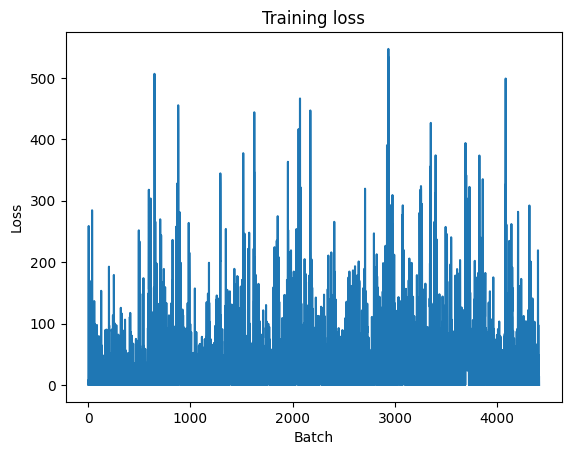

Loss на обучающей выборке: 49.49320


In [35]:


from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))




In [36]:
!nvidia-smi

Tue Mar 19 15:28:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX110           Off | 00000000:01:00.0 Off |                  N/A |
| N/A   67C    P0              N/A / 200W |   1987MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))



Процент правильных предсказаний на валидационной выборке: 51.43%
